# Copyright 2020 Google LLC.
 Licensed under the Apache License, Version 2.0 (the "License");
 you may not use this file except in compliance with the License.
 You may obtain a copy of the License at

 https://www.apache.org/licenses/LICENSE-2.0

 Unless required by applicable law or agreed to in writing, software
 distributed under the License is distributed on an "AS IS" BASIS,
 WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
 See the License for the specific language governing permissions and
| limitations under the License.

In [2]:
# from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import layers

from matplotlib import pyplot as plt

# The following lines adjust the granularity of reporting.
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

tf.keras.backend.set_floatx('float32')

print("Imported the modules.")

Imported the modules.


In [3]:
# Load the dataset
train_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")
test_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv")

# Scale the labels
scale_factor = 1000.0
# Scale the training set's label.
train_df["median_house_value"] /= scale_factor 

# Scale the test set's label
test_df["median_house_value"] /= scale_factor

# Shuffle the examples
train_df = train_df.reindex(np.random.permutation(train_df.index))

In [4]:
#@title Define functions to create and train a model, and a plotting function
def create_model(my_learning_rate, feature_layer):
    """Create and compile a simple linear regression model."""
    # Most simple tf.keras models are sequential.
    model = tf.keras.models.Sequential()

    # Add the layer containing the feature columns to the model.
    model.add(feature_layer)

    # Add one linear layer to the model to yield a simple linear regressor.
    model.add(tf.keras.layers.Dense(units=1, input_shape=(1,)))

    # Construct the layers into a model that TensorFlow can execute.
    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.RootMeanSquaredError()])

    return model           


def train_model(model, dataset, epochs, batch_size, label_name):
    """Feed a dataset into the model in order to train it."""

    # Question: Maybe we should pass a 1-d array (single feature) for this model?
    features = {name:np.array(value) for name, value in dataset.items()}
    label = np.array(features.pop(label_name))
    history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=True)

    # The list of epochs is stored separately from the rest of history.
    epochs = history.epoch

    # Isolate the mean absolute error for each epoch.
    hist = pd.DataFrame(history.history)
    rmse = hist["root_mean_squared_error"]

    return epochs, rmse   


def plot_the_loss_curve(epochs, rmse):
    """Plot a curve of loss vs. epoch."""

    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Root Mean Squared Error")

    plt.plot(epochs, rmse, label="Loss")
    plt.legend()
    plt.ylim([rmse.min()*0.94, rmse.max()* 1.05])
    plt.show()  

print("Defined the create_model, train_model, and plot_the_loss_curve functions.")

Defined the create_model, train_model, and plot_the_loss_curve functions.


In [16]:
features = {name:np.array(value) for name, value in train_df.items()}
label = np.array(features.pop(label_name))
print(features)

{'longitude': array([-121.86, -117.75, -122.53, ..., -120.25, -122.32, -122.73]), 'latitude': array([37.32, 34.07, 37.98, ..., 37.04, 38.01, 38.42]), 'housing_median_age': array([13., 52., 32., ..., 21., 26., 26.]), 'total_rooms': array([2519., 1548., 2390., ..., 1724., 3054., 1446.]), 'total_bedrooms': array([581., 348., 336., ..., 317., 492., 296.]), 'population': array([2094., 1131.,  810., ..., 1006., 1495.,  884.]), 'households': array([530., 343., 354., ..., 290., 496., 295.]), 'median_income': array([4.3621, 2.63  , 8.5759, ..., 3.2868, 4.6944, 4.3523])}


The following code cell represents latitude and longitude in buckets (bins). Each bin represents all the neighborhoods within a single degree. For example, neighborhoods at latitude 35.4 and 35.8 are in the same bucket, but neighborhoods in latitude 35.4 and 36.2 are in different buckets.
The model will learn a separate weight for each bucket. For example, the model will learn one weight for all the neighborhoods in the "35" bin", a different weight for neighborhoods in the "36" bin, and so on. This representation will create approximately 20 buckets:

10 buckets for latitude.
10 buckets for longitude.

In [5]:
resolution_in_degrees = 1.0 

# Create a new empty list that will eventually hold the generated feature column.
feature_columns = []

# Create a bucket feature column for latitude.
latitude_as_a_numeric_column = tf.feature_column.numeric_column("latitude")
latitude_boundaries = list(np.arange(int(min(train_df['latitude'])), 
                                     int(max(train_df['latitude'])), 
                                     resolution_in_degrees))
latitude = tf.feature_column.bucketized_column(latitude_as_a_numeric_column, 
                                               latitude_boundaries)
feature_columns.append(latitude)

# Create a bucket feature column for longitude.
longitude_as_a_numeric_column = tf.feature_column.numeric_column("longitude")
longitude_boundaries = list(np.arange(int(min(train_df['longitude'])), 
                                      int(max(train_df['longitude'])), 
                                      resolution_in_degrees))
longitude = tf.feature_column.bucketized_column(longitude_as_a_numeric_column, 
                                                longitude_boundaries)
feature_columns.append(longitude)

# Convert the list of feature columns into a layer that will ultimately become
# part of the model. Understanding layers is not important right now.
buckets_feature_layer = layers.DenseFeatures(feature_columns)

Epoch 1/35
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
170/170 [==============================] - 0s 446us/step - loss: 52224.0820 - root_mean_squared_error: 228.5259
Epoch 2/35
170/170 [==============================] - 0s 498us/step - loss: 44815.6484 - root_mean_squared_error: 211.6971
Epoch 3/35
170/170 [==============================] - 0s 418us/step - loss: 38194.9102 - root_mean_squared_error: 195.4352
Epoch 4/35
170/170 [==============================] - 0s 445us/step - loss: 32402.9219 - root_mean_squared_error: 180.0081
Epoch 5/35
170/170 [==============================] - 0s 436us/step - loss: 27356.5547 - root_mean_squared_error: 165.3982
Epoch 6/35
170/170 [==============================] - 0s 470us/step - loss: 23090.7031 - root_mean_squared_error: 151.9563
Epoch 7/35
170/170 [==============================] - 0s 451us/step - loss: 19561.4785 - root_mean_squared_error: 139.8624
Epoch 8/35
170/170 [=========

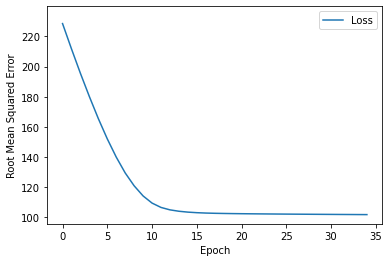


: Evaluate the new model against the test set:
Consider rewriting this model with the Functional API.
30/30 [==============================] - 0s 388us/step - loss: 10200.7520 - root_mean_squared_error: 100.9988


[10200.751953125, 100.99877166748047]

In [11]:
# The following variables are the hyperparameters.
learning_rate = 0.04
epochs = 35
batch_size = 100
label_name = 'median_house_value'

# Build the model, this time passing in the buckets_feature_layer.
my_model = create_model(learning_rate, buckets_feature_layer)

# Train the model on the training set.
epochs, rmse = train_model(my_model, train_df, epochs, batch_size, label_name)

plot_the_loss_curve(epochs, rmse)

print("\n: Evaluate the new model against the test set:")
test_features = {name:np.array(value) for name, value in test_df.items()}
test_label = np.array(test_features.pop(label_name))
my_model.evaluate(x=test_features, y=test_label, batch_size=batch_size)

Representing location as a feature cross should 
produce better results.

In Task 2, you represented latitude in 
one-dimensional buckets and longitude in 
another series of one-dimensional buckets. 
Real-world locations, however, exist in 
two dimension. Therefore, you should
represent location as a two-dimensional feature
cross. That is, you'll cross the 10 or so latitude 
buckets with the 10 or so longitude buckets to 
create a grid of 100 cells. 

The model will learn separate weights for each 
of the cells.

In [12]:
resolution_in_degrees = 1.0 

# Create a new empty list that will eventually hold the generated feature column.
feature_columns = []

# Create a bucket feature column for latitude.
latitude_as_a_numeric_column = tf.feature_column.numeric_column("latitude")
latitude_boundaries = list(np.arange(int(min(train_df['latitude'])), int(max(train_df['latitude'])), resolution_in_degrees))
latitude = tf.feature_column.bucketized_column(latitude_as_a_numeric_column, latitude_boundaries)

# Create a bucket feature column for longitude.
longitude_as_a_numeric_column = tf.feature_column.numeric_column("longitude")
longitude_boundaries = list(np.arange(int(min(train_df['longitude'])), int(max(train_df['longitude'])), resolution_in_degrees))
longitude = tf.feature_column.bucketized_column(longitude_as_a_numeric_column, longitude_boundaries)

# Create a feature cross of latitude and longitude.
latitude_x_longitude = tf.feature_column.crossed_column([latitude, longitude], hash_bucket_size=100)
crossed_feature = tf.feature_column.indicator_column(latitude_x_longitude)
feature_columns.append(crossed_feature)

# Convert the list of feature columns into a layer that will later be fed into
# the model. 
feature_cross_feature_layer = layers.DenseFeatures(feature_columns)

Epoch 1/35
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
170/170 [==============================] - 0s 514us/step - loss: 53547.0312 - root_mean_squared_error: 231.4023
Epoch 2/35
170/170 [==============================] - 0s 528us/step - loss: 48509.7188 - root_mean_squared_error: 220.2492
Epoch 3/35
170/170 [==============================] - 0s 500us/step - loss: 43829.1250 - root_mean_squared_error: 209.3541
Epoch 4/35
170/170 [==============================] - 0s 485us/step - loss: 39470.3906 - root_mean_squared_error: 198.6716
Epoch 5/35
170/170 [==============================] - 0s 559us/step - loss: 35455.5156 - root_mean_squared_error: 188.2964
Epoch 6/35
170/170 [==============================] - 0s 528us/step - loss: 31778.4023 - root_mean_squared_error: 178.2650
Epoch 7/35
170/170 [==============================] - 0s 515us/step - loss: 28418.6426 - root_mean_squared_error: 168.5783
Epoch 8/35
170/170 [=========

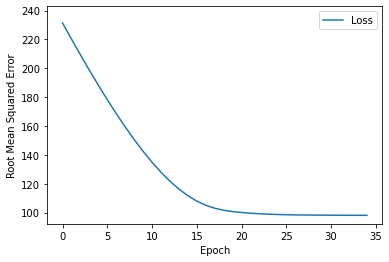


: Evaluate the new model against the test set:
Consider rewriting this model with the Functional API.
30/30 [==============================] - 0s 473us/step - loss: 9520.9336 - root_mean_squared_error: 97.5753


[9520.93359375, 97.57527160644531]

In [14]:
# The following variables are the hyperparameters.
learning_rate = 0.04
epochs = 35
label_name = 'median_house_value'

# Build the model, this time passing in the feature_cross_feature_layer: 
my_model = create_model(learning_rate, feature_cross_feature_layer)

# Train the model on the training set.
epochs, rmse = train_model(my_model, train_df, epochs, batch_size, label_name)

plot_the_loss_curve(epochs, rmse)

print("\n: Evaluate the new model against the test set:")
my_model.evaluate(x=test_features, y=test_label, batch_size=batch_size)

A resolution of ~0.4 degree provides the best results.